# Replication of Chapelle and Li

This notebook is a replication of the Chapelle and Li paper: https://papers.nips.cc/paper/4321-an-empirical-evaluation-of-thompson-sampling.pdf (An empirical evaluation of Thompson sampling)

# Load packages

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import kl_div
import time
import pandas as pd

# Define functions

In [2]:
def ALB_precalc(rewards): # Asymptotic lower bound pre-calc
    
    p_star = np.max(rewards)  
    result = 0
    for i in range(1, len(rewards)):
        result += ((p_star - rewards[i])/ compute_kl_divergence(p_star, rewards[i]))
        
    return result

def compute_kl_divergence(p_probs, q_probs):
    """"KL (p || q)"""
    kl_div = p_probs * np.log(p_probs / q_probs)
    return np.sum(kl_div)

In [3]:
def UCB(arm, t, M, ucb_R): # Upper Confidence Bound
    
    m = M[arm] 
    k = ucb_R[arm]
    delta = (1/(t+1)) **0.5
    
    num1 = k/m
    num2 = ((2 * (k/m) * np.log(1/delta))/m) **0.5
    num3 = (2 * np.log(1/delta)) / m
    
    return(num1+num2+num3)

# Define parameters

In [4]:
params = [[10,0.02, 6], # Tuple indicates k, epsilon and 10th power of max X iteration
          [10,0.1, 6],
          [100,0.02, 6],
          [100,0.1, 6]]
num_iters = 10 # Number of simulations to average results over

# 1) Run simulation

In [5]:
starttime = time.time()

# Initialise results dictionaries
ts_regret = {}
ucb_regret = {}

# Loop over parameter combinations (# of arms and epsilon, difference between reward distributions probability of reward)
for K, eps, T in params:
    
    # INITIALISE REWARDS AND RESULTS
    rewards = [0.5 - eps] * K # All rewards should be 0.5 - epsilon except...
    rewards[0] = 0.5 # Rewards in the best arm!
    ts_result = np.zeros(10**T) # Thompson sampling results array
    ucb_result = np.zeros(10**T) # Upper Confidence Bound results array
   
    # Repeat to achieve an average for the run (rather than relying on one simulation)
    for rep in range(0, num_iters):
        
        if rep % 20 == 0:
            print('k', str(K), '_eps', str(eps), '_rep', str(rep), 'That took {} seconds'.format(time.time() - starttime))
    
        # INITIALISE PRIORS AND COUNTERS
        alpha = [1] * K # Alpha prior for beta distribution
        beta = [1] * K # Beta prior for beta distribution
        S = [0] * K # Success counter for each arm 
        F = [0] * K # Failure counter for each arm
        M = [1] * K # Total trials counter per arm
        ucb_R = [0] * K # # Total reward counter per arm for UCB results

        for t in range(0, (10 ** T)):
            
            # FIND BEST ARM ACCORDING TO THOMPSON SAMPLING AND UCB
            ts_theta_max = 0 # Maximum thompson draw
            ts_k_max = 0 # Arm associated with max thompson draw
            ucb_max = 0 # Maximum Upper Confidence bound
            ucb_k_max = 0 # Arm associated with Upper Confidence Bound
            
            for i in range(0, K):
                
                ts_theta_i = np.random.beta((S[i]+ alpha[i]), (F[i-1] + beta[i])) # Random beta draw according to priors for each arm
                if ts_theta_i > ts_theta_max:                   
                    ts_theta_max = ts_theta_i
                    ts_k_max = i 
                    
                ucb_i = UCB(i, t, M, ucb_R) # Calculate Upper Confidence Bound for each draw
                if ucb_i > ucb_max:
                    ucb_max = ucb_i
                    ucb_k_max = i
            
            # Record results
            if ts_k_max != 0:
                ts_result[t] += eps

            S[ts_k_max] += 1 
            F[-ts_k_max] += 1
                       
            if ucb_k_max != 0:
                ucb_result[t] += eps
                ucb_R[ucb_k_max] += (0.5 - eps)
            else: 
                ucb_R[ucb_k_max] += 0.5
          
            M[ucb_k_max] += 1
            
            
            # Update parameters every 100 iterations
            if t % 100 == 0:
                alpha = np.add(alpha, S)
                S = [0] * K
                beta = np.add(beta, F)
                F = [0] * K
                           
    
    ts_regret[('k' + str(K) + '_eps_' + str(eps))] = ( ts_result.cumsum() ) / num_iters
    ucb_regret[('k' + str(K) + '_eps_' + str(eps))] = ( ucb_result.cumsum() ) / num_iters
    
print('That took {} seconds'.format(time.time() - starttime))
            

k 10 _eps 0.02 _rep 0 That took 0.0006048679351806641 seconds
k 10 _eps 0.1 _rep 0 That took 754.0562670230865 seconds
k 100 _eps 0.02 _rep 0 That took 1497.109403848648 seconds
k 100 _eps 0.1 _rep 0 That took 8729.784303188324 seconds
That took 16004.355324983597 seconds


In [9]:
# CALCULATE ASYMPTOTIC LOWER BOUND
alb = {}

for K, eps, T in params:
    
    rewards = [0.5 - eps] * K # All rewards should be 0.5 - epsilon except...
    rewards[0] = 0.5 
    
    precalc_ALB = ALB_precalc(rewards) # Initialise sum of (optimal p star - pi)/ KL (optimal p star, pi) for each k and eps 
    alb_result = np.zeros(10**6)
    
    for t in range(1, 10 **6):
        alb_result[t] = np.log(t) * precalc_ALB
        
    alb[('k' + str(K) + '_eps_' + str(eps))] = alb_result    

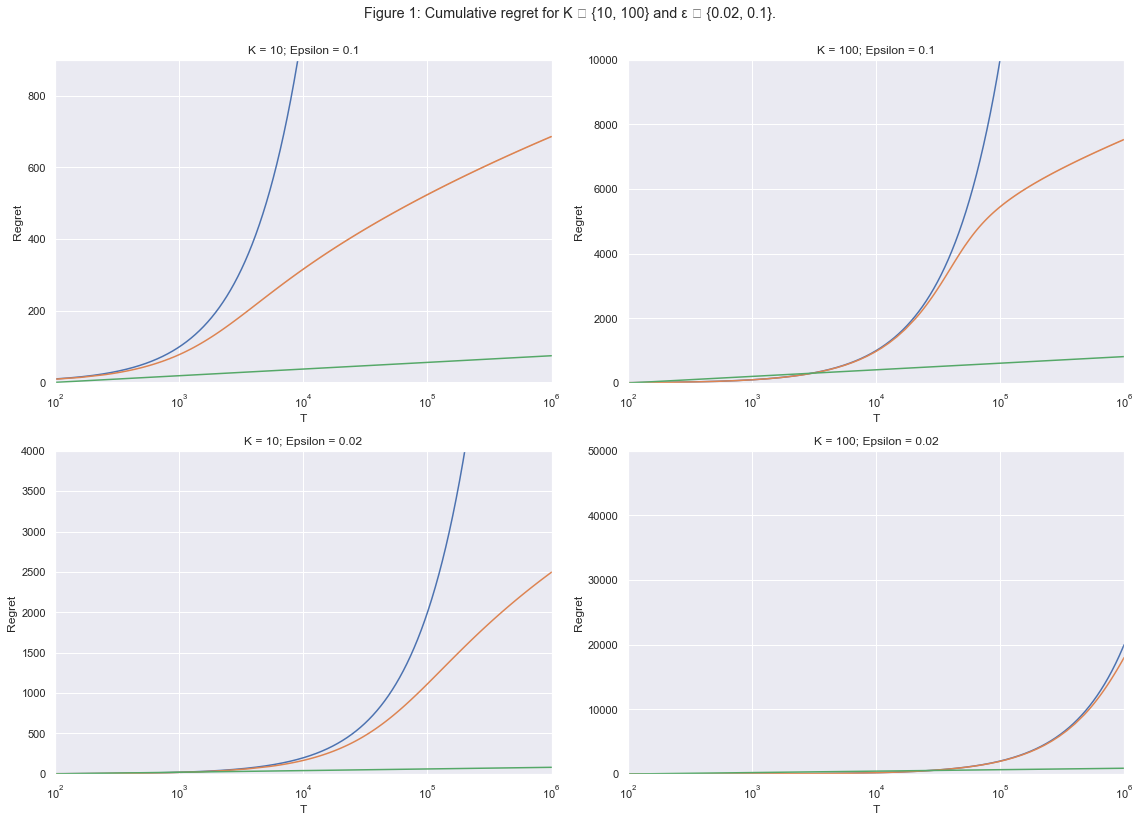

In [10]:
sns.set(rc={'figure.figsize':(16,12)})
fig, axs = plt.subplots(2,2)
fig.suptitle('Figure 1: Cumulative regret for K ∈ {10, 100} and ε ∈ {0.02, 0.1}.')

T=6

sns.lineplot(x= list(range(0, (10 ** T))), y= list(ts_regret['k10_eps_0.1']),  ax=axs[0,0]).set(title = 'K = 10; Epsilon = 0.1', xlabel="T", ylabel = "Regret")
sns.lineplot(x= list(range(0, (10 ** T))), y= list(ucb_regret['k10_eps_0.1']),  ax=axs[0,0])
sns.lineplot(x= list(range(0, (10 ** T))), y= list(alb['k10_eps_0.1']-alb['k10_eps_0.1'][10**2]),  ax=axs[0,0]).set(xscale="log", xlim=(10**2,10**6), ylim=(-2,900))

sns.lineplot(x= list(range(0, (10 ** T))), y= list(ts_regret['k10_eps_0.02']),  ax=axs[1,0]).set(title = 'K = 10; Epsilon = 0.02', xlabel="T", ylabel = "Regret")
sns.lineplot(x= list(range(0, (10 ** T))), y= list(ucb_regret['k10_eps_0.02']), ax = axs[1,0])
sns.lineplot(x= list(range(0, (10 ** T))), y= list(alb['k10_eps_0.02']- alb['k10_eps_0.02'][10**2]), ax = axs[1,0]).set(xscale="log", xlim=(10**2,10**6), ylim=(-2,4000))

sns.lineplot(x= list(range(0, (10 ** T))), y= list(ts_regret['k100_eps_0.1']),  ax=axs[0,1]).set(title = 'K = 100; Epsilon = 0.1', xlabel="T", ylabel = "Regret")
sns.lineplot(x= list(range(0, (10 ** T))), y= list(ucb_regret['k100_eps_0.1']), ax = axs[0,1])
sns.lineplot(x= list(range(0, (10 ** T))), y= list(alb['k100_eps_0.1']- alb['k100_eps_0.1'][10**2]), ax = axs[0,1]).set(xscale= "log", xlim=(10**2,10**6), ylim=(-2,10000))

sns.lineplot(x= list(range(0, (10 ** T))), y= list(ts_regret['k100_eps_0.02']),  ax=axs[1,1]).set(title = 'K = 100; Epsilon = 0.02', xlabel="T", ylabel = "Regret")
sns.lineplot(x= list(range(0, (10 ** T))), y= list(ucb_regret['k100_eps_0.02']), ax = axs[1,1])
sns.lineplot(x= list(range(0, (10 ** T))), y= list(alb['k100_eps_0.02']- alb['k100_eps_0.02'][10**2]), ax = axs[1,1]).set(xscale = "log", xlim=(10**2,10**6), ylim=(-2,50000))
             
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# 2) Additional simulation

- My original simulation calculated regret in the incorrect way- but nonetheless showed interesting results so I include it here!
- Instead of using a fixed regret term based on whether or not the correct arm was chosen, here the rewards are actually pulled from a binomial using the reward probabilities of the best arm chosen by each method- thompson sampling, UCB and also the the optimal arm. Then the actual regret is calculated using the difference between the optimal pull and the thompson/UCB arms. 
- Because the results are averaged over 100 runs, we see comparable results to the correct method but with additional variance, which comes from the stochasticity associated with the binomial draws for both the thompson/UCB arms and the optimal arms. As n> infinity these results should converge to the same thing.

In [5]:
starttime = time.time()

# Initialise results dictionaries
ts_regret = {}
ucb_regret = {}

# Loop over parameter combinations (# of arms and epsilon, difference between reward distributions probability of reward)
for K, eps, T in params:
    
    # INITIALISE REWARDS AND RESULTS
    rewards = [0.5 - eps] * K # All rewards should be 0.5 - epsilon except...
    rewards[0] = 0.5 # Rewards in the best arm!
    ts_result = np.zeros(10**T) # Thompson sampling results array
    ucb_result = np.zeros(10**T) # Upper Confidence Bound results array
    opt_result = np.zeros(10**T) # Optimal policy results array
   
    # Repeat to achieve an average for the run (rather than relying on one simulation)
    for rep in range(0, num_iters):
        
        if rep % 20 == 0:
            print('k', str(K), '_eps', str(eps), '_rep', str(rep), 'That took {} seconds'.format(time.time() - starttime))
    
        # INITIALISE PRIORS AND COUNTERS
        alpha = [1] * K # Alpha prior for beta distribution
        beta = [1] * K # Beta prior for beta distribution
        S = [0] * K # Success counter for each arm 
        F = [0] * K # Failure counter for each arm
        M = [1] * K # Total trials counter per arm
        ucb_R = [0] * K # All successes per arm counter

        for t in range(0, (10 ** T)):
            
            # FIND BEST ARM ACCORDING TO THOMPSON SAMPLING AND UCB
            ts_theta_max = 0 # Maximum thompson draw
            ts_k_max = 0 # Arm associated with max thompson draw
            ucb_max = 0 # Maximum Upper Confidence bound
            ucb_k_max = 0 # Arm associated with Upper Confidence Bound
            
            for i in range(0, K):
                
                ts_theta_i = np.random.beta((S[i]+ alpha[i]), (F[i-1] + beta[i])) # Random beta draw according to priors for each arm
                if ts_theta_i > ts_theta_max:                   
                    ts_theta_max = ts_theta_i
                    ts_k_max = i 
                    
                ucb_i = UCB(i, t) # Calculate Upper Confidence Bound for each draw
                if ucb_i > ucb_max:
                    ucb_max = ucb_i
                    ucb_k_max = i
            
            # Draw rewards from binomial according to best arm identified using different methods
            ts_reward = np.random.binomial(1, rewards[ts_k_max])
            ucb_reward = np.random.binomial(1, rewards[ucb_k_max])
            opt_reward = np.random.binomial(1, 0.5)
            
            # Record results
            ts_result[t] += ts_reward
            opt_result[t] += opt_reward
            ucb_result[t] += ucb_reward
          
            # Update reward and failure counters after every iteration
            if ts_reward == 1: S[ts_k_max] += 1
            else: F[ts_k_max] +=1
                
            ucb_R[ucb_k_max] += ucb_reward
            M[ucb_k_max] += 1
            
            # Update parameters every 100 iterations
            if t % 100 == 0:
                alpha = np.add(alpha, S)
                S = [0] * K
                beta = np.add(beta, F)
                F = [0] * K
                           
    
    ts_regret[('k' + str(K) + '_eps_' + str(eps))] = (opt_result.cumsum() - ts_result.cumsum() ) / num_iters
    ucb_regret[('k' + str(K) + '_eps_' + str(eps))] = (opt_result.cumsum() - ucb_result.cumsum() ) / num_iters
    
print('That took {} seconds'.format(time.time() - starttime))
            

k 10 _eps 0.02 _rep 0 That took 0.0026590824127197266 seconds
k 10 _eps 0.02 _rep 20 That took 2098.7871589660645 seconds
k 10 _eps 0.02 _rep 40 That took 4087.4029569625854 seconds
k 10 _eps 0.1 _rep 0 That took 5142.566689968109 seconds
k 10 _eps 0.1 _rep 20 That took 7170.063650131226 seconds
k 10 _eps 0.1 _rep 40 That took 9265.91720199585 seconds
k 100 _eps 0.02 _rep 0 That took 10462.49126791954 seconds
k 100 _eps 0.02 _rep 20 That took 27523.651052951813 seconds
k 100 _eps 0.02 _rep 40 That took 43929.083318948746 seconds
k 100 _eps 0.1 _rep 0 That took 51767.38209295273 seconds
k 100 _eps 0.1 _rep 20 That took 67429.12910890579 seconds
k 100 _eps 0.1 _rep 40 That took 84016.55383896828 seconds
That took 92271.18092179298 seconds


In [28]:
# CALCULATE ASYMPTOTIC LOWER BOUND
alb = {}

for K, eps, T in params:
    
    rewards = [0.5 - eps] * K # All rewards should be 0.5 - epsilon except...
    rewards[0] = 0.5 
    
    precalc_ALB = ALB_precalc(rewards) # Initialise sum of (optimal p star - pi)/ KL (optimal p star, pi) for each k and eps 
    alb_result = np.zeros(10**6)
    
    for t in range(1, 10 **6):
        alb_result[t] = np.log(t) * precalc_ALB
        
    alb[('k' + str(K) + '_eps_' + str(eps))] = alb_result     

In [50]:
alb['k10_eps_0.1'][10**2]

37.14786417065821

# Plot results

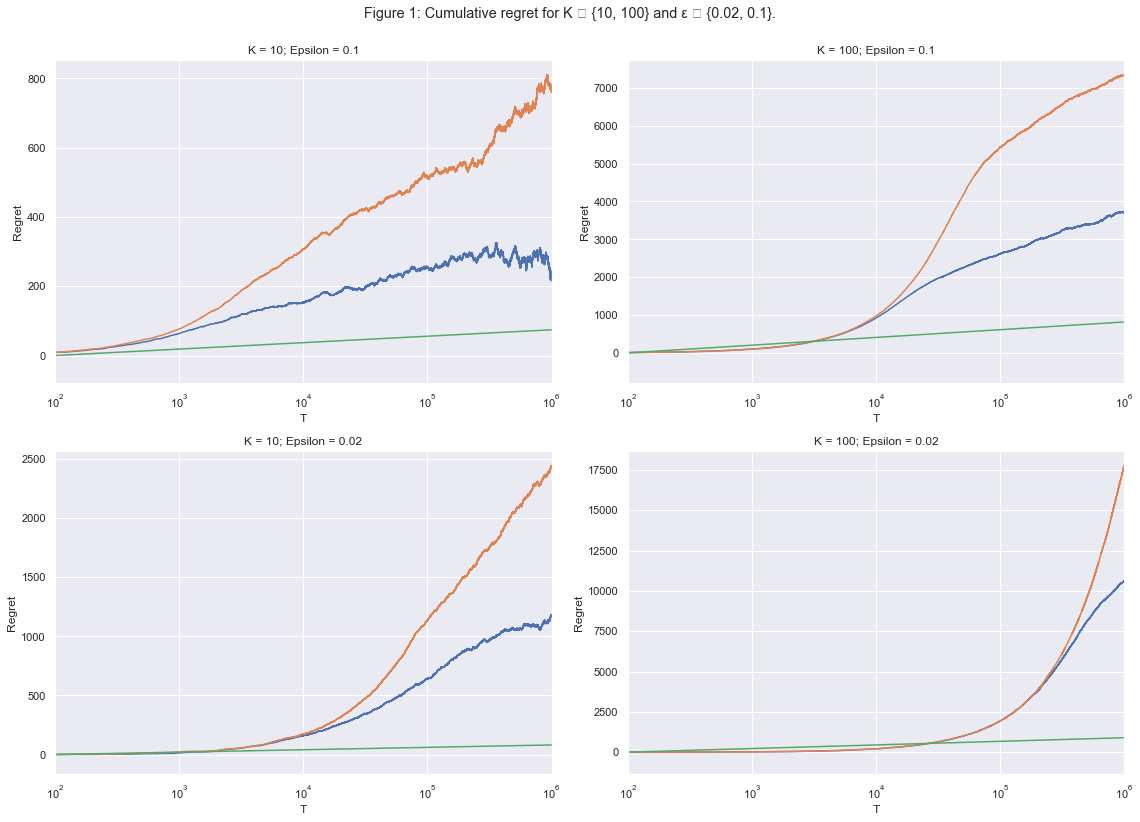

In [51]:
sns.set(rc={'figure.figsize':(16,12)})
fig, axs = plt.subplots(2,2)
fig.suptitle('Figure 1: Cumulative regret for K ∈ {10, 100} and ε ∈ {0.02, 0.1}.')



sns.lineplot(x= list(range(0, (10 ** 6))), y= list(ts_regret['k10_eps_0.1']),  ax=axs[0,0]).set(title = 'K = 10; Epsilon = 0.1', xlabel="T", ylabel = "Regret")
sns.lineplot(x= list(range(0, (10 ** 6))), y= list(ucb_regret['k10_eps_0.1']),  ax=axs[0,0])
sns.lineplot(x= list(range(0, (10 ** 6))), y= list(alb['k10_eps_0.1']-alb['k10_eps_0.1'][10**2]),  ax=axs[0,0]).set(xscale="log", xlim=(10**2,10**6))

sns.lineplot(x= list(range(0, (10 ** 6))), y= list(ts_regret['k10_eps_0.02']),  ax=axs[1,0]).set(title = 'K = 10; Epsilon = 0.02', xlabel="T", ylabel = "Regret")
sns.lineplot(x= list(range(0, (10 ** 6))), y= list(ucb_regret['k10_eps_0.02']), ax = axs[1,0])
sns.lineplot(x= list(range(0, (10 ** 6))), y= list(alb['k10_eps_0.02']- alb['k10_eps_0.02'][10**2]), ax = axs[1,0]).set(xscale="log", xlim=(10**2,10**6))

sns.lineplot(x= list(range(0, (10 ** 6))), y= list(ts_regret['k100_eps_0.1']),  ax=axs[0,1]).set(title = 'K = 100; Epsilon = 0.1', xlabel="T", ylabel = "Regret")
sns.lineplot(x= list(range(0, (10 ** 6))), y= list(ucb_regret['k100_eps_0.1']), ax = axs[0,1])
sns.lineplot(x= list(range(0, (10 ** 6))), y= list(alb['k100_eps_0.1']- alb['k100_eps_0.1'][10**2]), ax = axs[0,1]).set(xscale= "log", xlim=(10**2,10**6))

sns.lineplot(x= list(range(0, (10 ** 6))), y= list(ts_regret['k100_eps_0.02']),  ax=axs[1,1]).set(title = 'K = 100; Epsilon = 0.02', xlabel="T", ylabel = "Regret")
sns.lineplot(x= list(range(0, (10 ** 6))), y= list(ucb_regret['k100_eps_0.02']), ax = axs[1,1])
sns.lineplot(x= list(range(0, (10 ** 6))), y= list(alb['k100_eps_0.02']- alb['k100_eps_0.02'][10**2]), ax = axs[1,1]).set(xscale = "log", xlim=(10**2,10**6))
             
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save results

In [9]:
import pickle
with open('ucb_regret_2.pkl', 'wb') as f:
       pickle.dump(ucb_regret, f)
        
import pickle
with open('ts_regret_2.pkl', 'wb') as f:
       pickle.dump(ts_regret, f)